# Building and Training a Simple RNN Model using PyTorch for Predicting Sine Wave Patterns

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Generate data

Let's create a simple dataset to train our network on. We'll use a sine wave as the input sequence and try to predict the next value in the sequence. We'll create a dataset of 1000 sequences with 10 time steps each.

In [ ]:
"""
Generates synthetic sine wave sequences for time series forecasting.

Creates input-output pairs where each input is a segment of a sine wave with random phase shift,
and the output is the immediate next point in the sequence after the input window.

Parameters:
    timesteps (int): Length of each input sequence (window size)
    data_size (int): Total number of sequences to generate

Variables:
    input_data (np.ndarray): Generated input sequences 
        Shape: (data_size, timesteps, 1)
    output_data (np.ndarray): Corresponding target values
        Shape: (data_size, 1)

Process:
    1. Initializes empty arrays for inputs and outputs
    2. For each sequence:
        - Generates random phase offset (0 to 2π)
        - Creates input sequence from sine wave over range [0, 3π] with offset
        - Sets output as sine value at 3π + offset
    3. Returns filled arrays

Example:
    Generates 1000 sequences of length 10:
    >>> timesteps = 10
    >>> data_size = 1000
    >>> input_data, output_data = generate_sequences()
    >>> input_data.shape
    (1000, 10, 1)
"""

timesteps = 10
data_size = 1000

input_data = np.zeros((data_size, timesteps, 1))
output_data = np.zeros((data_size, 1))

for i in range(data_size):
    rand_offset = np.random.random() * 2 * np.pi
    input_data[i, :, 0] = np.sin(np.linspace(0.0 + rand_offset, 3 * np.pi + rand_offset, num=timesteps))
    output_data[i, 0] = np.sin(3 * np.pi + rand_offset)

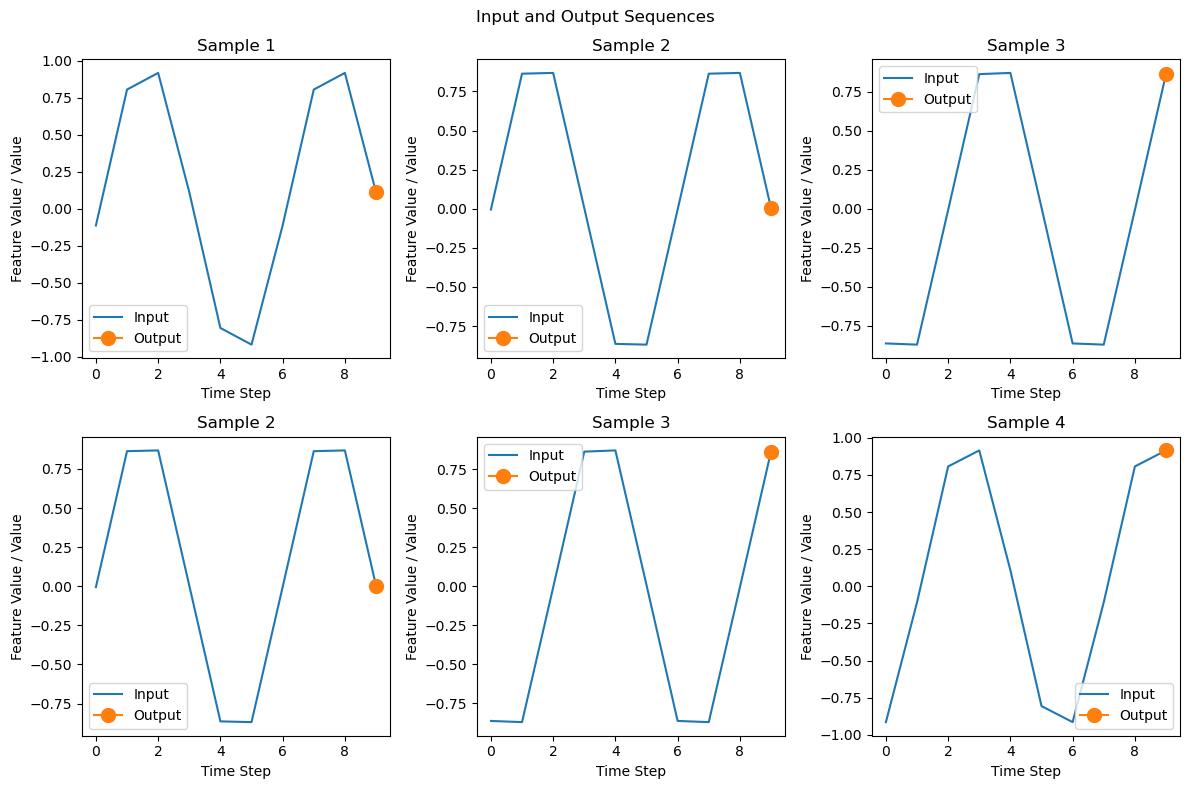

In [ ]:
""" Visualizes sample input-output sequences from time series data.

Creates a 2x3 grid of plots showing:

- Input sequences as line plots
- Corresponding output values as large markers
- Proper labeling for interpretation

Parameters: 

    - input_data (np.ndarray): Input sequences | Shape: (num_samples, timesteps, 1) 
    - output_data (np.ndarray): Target values | Shape: (num_samples, 1) 
    - timesteps (int): Length of input sequences

Process: 

    1. Creates 2x3 subplot grid 
    2. Plots first 6 samples (input sequence + output point) 
    3. Formats each subplot with: 
    - Title showing sample number
    - X/Y axis labels - Legend distinguishing input/output 4. Adds overall title and adjusts layout

Example Output: Displays 6 side-by-side plots showing: - Blue line: Input sequence (10 timesteps) - Orange dot: Corresponding 
output value - Clear labels and legends for each subplot 
"""

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(2):
    for j in range(3):
        # plot input sequence
        axs[i,j].plot(input_data[i+j,:,0], label='Input')

        # plot output value with big marker
        axs[i,j].plot(range(timesteps-1, timesteps), output_data[i+j], marker='o', markersize=10, label='Output')

        # set plot title, axis labels, and legend
        axs[i,j].set_title(f'Sample {i+j+1}')
        axs[i,j].set_xlabel('Time Step')
        axs[i,j].set_ylabel('Feature Value / Value')
        axs[i,j].legend()

plt.suptitle('Input and Output Sequences')
plt.tight_layout()
plt.show()

Now, let's split the dataset into training and testing sets:

In [4]:
train_size = int(data_size * 0.8)

X_train = input_data[:train_size, :, :]
y_train = output_data[:train_size, :]

X_test = input_data[train_size:, :, :]
y_test = output_data[train_size:, :]

### Define the RNN model

We'll use a simple RNN with a single hidden layer:

In [5]:
class RnnNet(nn.Module):
    """
    A simple RNN-based neural network for time series prediction.

    Architecture:
        - RNN layer with 32 hidden units
        - Fully connected output layer
        - Processes sequences to single-step predictions

    Parameters in __init__:
        rnn (nn.RNN): 
            - input_size=1 (single feature)
            - hidden_size=32 (hidden units) 
            - num_layers=1 (single RNN layer)
            - batch_first=True (input shape: [batch, seq, feature])
        fc (nn.Linear):
            - in_features=32 (matches RNN hidden size)
            - out_features=1 (single output prediction)

    Forward Process:
        1. Input shape: [batch_size, sequence_length, 1]
        2. RNN processes full sequence
        3. Only last RNN output used (shape: [batch_size, 32])
        4. Linear layer produces final prediction (shape: [batch_size, 1])

    Example:
        >>> model = RnnNet()
        >>> x = torch.randn(64, 10, 1)  # batch of 64 sequences
        >>> output = model(x)
        >>> output.shape
        torch.Size([64, 1])
    """
    def __init__(self):
        super(RnnNet, self).__init__()

        # Create a new RNN layer with 1 input feature, 32 hidden units, and 1 layer
        self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True)

        # Create a new fully connected layer with 32 input features and 1 output feature
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        """
        Passes the input tensor through the RNN and the fully connected layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1)
        """
        # Pass the input tensor through the RNN layer, which returns a new tensor with
        # shape (batch_size, sequence_length, hidden_size)
        rnn_out, _ = self.rnn(x)

        # Pass the last output from the RNN layer through the fully connected layer,
        # which returns a new tensor with shape (batch_size, 1)
        fc_out = self.fc(rnn_out[:, -1, :])

        # Return the output tensor
        return fc_out

net = RnnNet()

We'll use mean squared error loss and the Adam optimizer:

In [6]:
"""
The MSE loss function is a commonly used loss function for regression problems. It measures the average of the squared 
differences between the predicted output and the true output. In our case, we want our RNN to predict the sine wave value 
at the last time step given the input sequence, which is a regression problem. Therefore, using the MSE loss function is 
appropriate.

The Adam optimizer is a popular stochastic gradient descent optimizer that is known for its efficiency and robustness. 
It adapts the learning rate for each parameter based on the first and second moments of the gradients. In other words, 
it adjusts the learning rate for each weight in the network based on how much and how quickly the weight is changing. 
This helps the optimizer converge faster and more reliably than other stochastic gradient descent optimizers. Therefore, 
using the Adam optimizer is a good choice for training our RNN.

In summary, we used the MSE loss function because we have a regression problem, and we used the Adam optimizer because 
it is efficient and robust.
"""

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

Now, we'll define our training loop. We'll train the network for 70 epochs and calculate the training and validation loss after each epoch:

In [7]:
"""
Executes the training loop for an RNN model with validation tracking.

Parameters:
    net (nn.Module): The RNN model to train
    X_train (np.ndarray): Training input sequences
    y_train (np.ndarray): Training target values
    X_test (np.ndarray): Validation input sequences
    y_test (np.ndarray): Validation target values
    criterion (nn.Module): Loss function (typically MSELoss)
    optimizer (torch.optim): Optimization algorithm (typically Adam)

Process Flow:
    1. Initializes empty lists for loss tracking
    2. For each epoch:
        a. Sets model to train mode
        b. Performs forward pass on training data
        c. Calculates and backpropagates loss
        d. Updates model parameters
        e. Evaluates model on validation set
        f. Records and prints both losses

Outputs:
    train_losses (list): Training loss per epoch
    val_losses (list): Validation loss per epoch

Example:
    >>> train_losses, val_losses = train_rnn(net, X_train, y_train, 
    ...                                     X_test, y_test, criterion, optimizer)
    >>> len(train_losses)
    70
"""
train_losses = []
val_losses = []

for epoch in range(70):
    net.train()
    optimizer.zero_grad()

    outputs = net(torch.Tensor(X_train))
    loss = criterion(outputs, torch.Tensor(y_train))

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    net.eval()
    with torch.no_grad():
        outputs = net(torch.Tensor(X_test))
        val_loss = criterion(outputs, torch.Tensor(y_test))
        val_losses.append(val_loss.item())

    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, 70, loss.item(), val_loss.item()))

Epoch [1/70], Train Loss: 0.5348, Val Loss: 0.4446
Epoch [2/70], Train Loss: 0.4194, Val Loss: 0.3422
Epoch [3/70], Train Loss: 0.3243, Val Loss: 0.2287
Epoch [4/70], Train Loss: 0.2171, Val Loss: 0.0793
Epoch [5/70], Train Loss: 0.0750, Val Loss: 0.0133
Epoch [6/70], Train Loss: 0.0135, Val Loss: 0.1272
Epoch [7/70], Train Loss: 0.1216, Val Loss: 0.0687
Epoch [8/70], Train Loss: 0.0663, Val Loss: 0.0065
Epoch [9/70], Train Loss: 0.0067, Val Loss: 0.0116
Epoch [10/70], Train Loss: 0.0108, Val Loss: 0.0347
Epoch [11/70], Train Loss: 0.0325, Val Loss: 0.0471
Epoch [12/70], Train Loss: 0.0445, Val Loss: 0.0470
Epoch [13/70], Train Loss: 0.0447, Val Loss: 0.0374
Epoch [14/70], Train Loss: 0.0358, Val Loss: 0.0225
Epoch [15/70], Train Loss: 0.0216, Val Loss: 0.0078
Epoch [16/70], Train Loss: 0.0076, Val Loss: 0.0004
Epoch [17/70], Train Loss: 0.0005, Val Loss: 0.0052
Epoch [18/70], Train Loss: 0.0050, Val Loss: 0.0164
Epoch [19/70], Train Loss: 0.0157, Val Loss: 0.0204
Epoch [20/70], Train 

Finally, let's plot the training and validation loss over epochs:

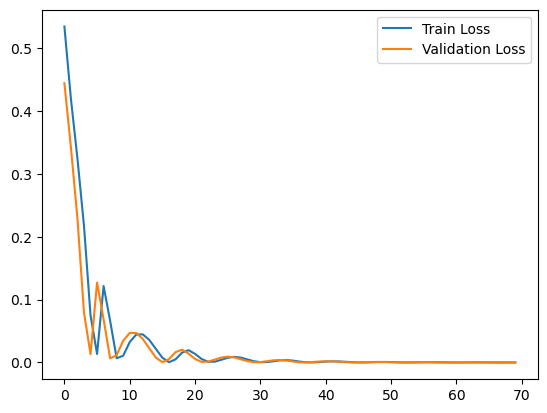

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()

plt.show()

And that's it! We've successfully trained a simple RNN to predict the next value in a sine wave sequence.